In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.eager as tfe

In [16]:
try:
    tfe.enable_eager_execution()
except ValueError:
    # Hide the annoying lack of idem-potency.
    pass

In [85]:
block_sizes = [3, 5, 5, 1]
dim = sum(block_sizes)

psd_args = dict(
    is_non_singular=True,
    is_self_adjoint=True,
    is_positive_definite=True,
)

diagonal = tf.zeros([dim])
variables = []

offset = 0
for block_size in block_sizes:
    pad_before = offset
    pad_after = dim - (offset + block_size)
    v = tfe.Variable(1.)
    variables.append(v)
    diagonal += tf.pad(tf.exp(v) * tf.ones([block_size]),
                       [[pad_before, pad_after]])
    offset += block_size
K = tf.linalg.LinearOperatorDiag(diagonal, **psd_args)


offset = 0
for block_size in block_sizes:
    pad_before = offset
    pad_after = dim - (offset + block_size)
    v = tfe.Variable(1.)
    variables.append(v)
    u = tf.pad(v * tf.ones([block_size, 1]),
               [[pad_before, pad_after], [0, 0]])
    K = tf.linalg.LinearOperatorLowRankUpdate(K, u=u, v=u, **psd_args)
    offset += block_size

In [86]:
K.log_abs_determinant()

<tf.Tensor: id=2245, shape=(), dtype=float32, numpy=17.144114>

In [87]:
# val_and_grad_fn = tfe.value_and_gradients_function(lambda K: K.log_abs_determinant())
# val_and_grad_fn(K)

In [88]:
K_tensor = K.matmul(tf.eye(K.shape[0].value))

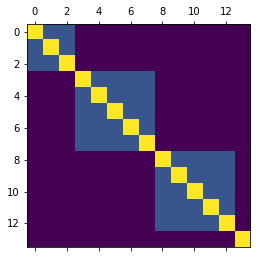

In [89]:
plt.matshow(K_tensor);

8

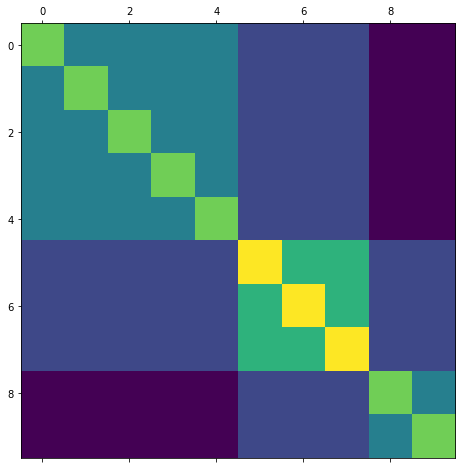

In [82]:
block_boundaries = [0, 5, 8, 10]
# block_boundaries = [0]
# block_boundaries.append(block_boundaries[-1] + 784 * 10)
# block_boundaries.append(block_boundaries[-1] + 10)
# block_boundaries.append(block_boundaries[-1] + 10 * 10)
# block_boundaries.append(block_boundaries[-1] + 10)
# block_boundaries.append(block_boundaries[-1] + 10 * 10)
# block_boundaries.append(block_boundaries[-1] + 10)



def outer(v):
    return tf.matmul(tf.reshape(v, (-1, 1)),
                     tf.reshape(v, (1, -1)))


def parametrized_precision(block_boundaries):
    variables = []
    n_params = block_boundaries[-1]
    K = tf.zeros(shape=(n_params, n_params))
    for i, j in zip(block_boundaries, block_boundaries[1:]):
        # Diagonal for the current block
        diag_mask_i = np.zeros(n_params, dtype=np.float32)
        diag_mask_i[i:j] = 1
        diag_mask_i = tf.constant(diag_mask_i)
        K_i_var = tfe.Variable(0.5, dtype=np.float32)
        K_i = tf.diag(tf.exp(K_i_var) * diag_mask_i)
        variables.append(K_i_var)
        K += K_i
        
        # Rank-one for the current parameter block
        ro_mask_i = np.zeros(n_params, dtype=np.float32)
        ro_mask_i[i:j] = 1
        ro_mask_i = tf.constant(ro_mask_i)
        ro_var_i = tfe.Variable(1, dtype=np.float32)
        ro_i = outer(ro_var_i * ro_mask_i)
        variables.append(ro_var_i)
        K += ro_i
    for i, j in zip(block_boundaries, block_boundaries[2:]):
        # Rank-one for consecutive blocks interactions
        ro_mask_i = np.zeros(n_params, dtype=np.float32)
        ro_mask_i[i:j] = 1
        ro_mask_i = tf.constant(ro_mask_i)
        ro_var_i = tfe.Variable(1., dtype=np.float32)
        ro_i = outer(ro_var_i * ro_mask_i)
        variables.append(ro_var_i)
        K += ro_i
    return variables, K

variables, K = parametrized_precision(block_boundaries)

fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(K)
len(variables)

In [8]:
tf.linalg.det(K)

<tf.Tensor: id=238, shape=(), dtype=float32, numpy=18083.262>

<tf.Tensor: id=240, shape=(10,), dtype=float32, numpy=
array([ 1.6487198,  1.6487209,  1.648721 ,  1.6487212,  1.6487212,
        1.6487212,  1.6487213,  4.268642 ,  8.341459 , 15.3360615],
      dtype=float32)>

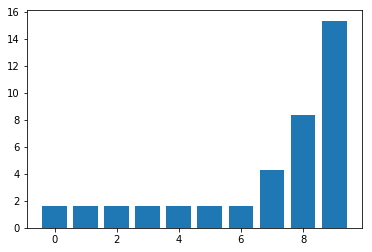

In [9]:
eigvals = tf.linalg.eigh(K)[0]
plt.bar(np.arange(K.numpy().shape[0]), eigvals)
eigvals

In [10]:
C = tf.linalg.inv(K)
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.matshow(C)

In [11]:
from tensorflow.contrib.distributions import MultivariateNormalFullCovariance


model = MultivariateNormalFullCovariance(loc=tf.zeros([C.shape[0]], dtype=np.float32), covariance_matrix=C)

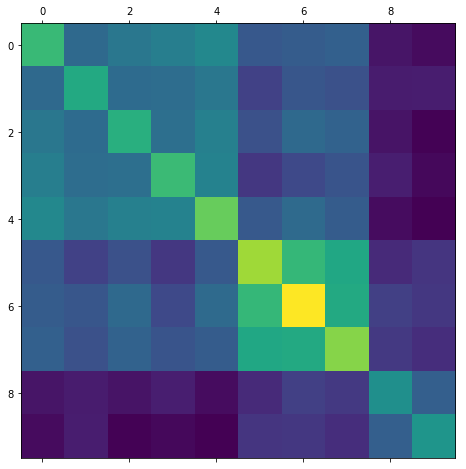

In [12]:
data = model.sample(100)
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(tf.linalg.inv(tf.matmul(tf.transpose(data), data)));

In [13]:
# from sklearn.covariance import graph_lasso

# gl = graph_lasso(np.asarray(tf.matmul(tf.transpose(data), data)), 1)
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.matshow(gl[1])

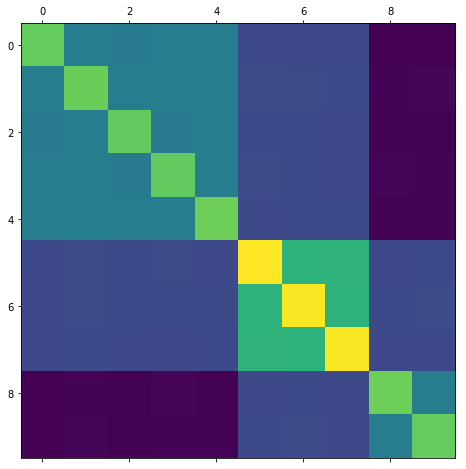

In [14]:
data_large = model.sample(10000)
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(tf.linalg.inv(tf.matmul(tf.transpose(data_large), data_large)));